<a href="https://colab.research.google.com/github/AhmedSSoliman/Hyperparameter-Search-with-Transformers-and-Ray-Tune/blob/main/Hyperparameter_Search_with_Transformers_and_Ray_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you’re leveraging `Transformers`, you’ll want to have a way to easily access powerful hyperparameter tuning solutions without giving up the customizability of the Transformers framework.

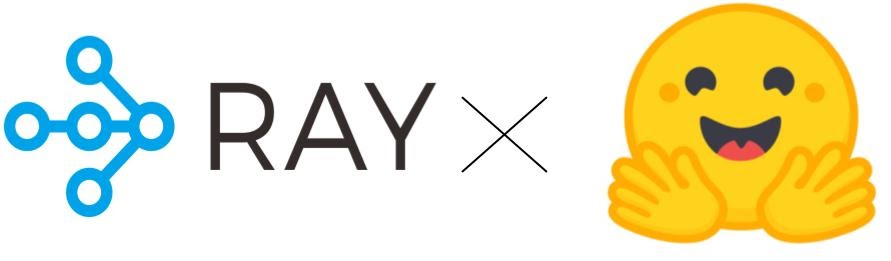

Hugging Face Transformers and Ray Tune teamed up to provide a simple yet powerful integration. Ray Tune is a popular Python library for hyperparameter tuning that provides many state-of-the-art algorithms out of the box, along with integrations with the best-of-class tooling, such as Weights and Biases and tensorboard.

To demonstrate this new Hugging Face + Ray Tune integration, we leverage the Hugging Face Datasets library to fine tune BERT on MRPC.

In [1]:
%%capture
!pip install "ray[tune]" transformers datasets scipy sklearn torch
!pip install hyperopt

In [2]:


from datasets import load_dataset, load_metric
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments)

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
dataset = load_dataset('glue', 'mrpc')
metric = load_metric('glue', 'mrpc')


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

In [3]:

def encode(examples):
    outputs = tokenizer(
        examples['sentence1'], examples['sentence2'], truncation=True)
    return outputs

encoded_dataset = dataset.map(encode, batched=True)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-uncased', return_dict=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)




  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [4]:

# Evaluate during training and a bit more often
# than the default to be able to prune bad trials early.
# Disabling tqdm is a matter of preference.
training_args = TrainingArguments(
    "test", evaluation_strategy="steps", eval_steps=500, disable_tqdm=True)
trainer = Trainer(
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    model_init=model_init,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.2",
  "vocab_size": 30522
}

https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpcy71w8k_


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight'

In [5]:
# Default objective is the sum of all metrics
# when metrics are provided, so we have to maximize it.
trainer.hyperparameter_search(
    direction="maximize", 
    backend="ray", 
    n_trials=10 # number of trials
)


No `resources_per_trial` arg was passed into `hyperparameter_search`. Setting it to a default value of 1 CPU and 1 GPU for each trial.
/usr/local/lib/python3.7/dist-packages/ray/_private/services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)


== Status ==
Memory usage on this node: 2.4/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-06-26
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|------------------------+----------+-------+-----------------+--------------------+-------------------------------+----------|
| _objective_4b1b9_00000 | RUNNING  |       |     5.61152e-06 |                  5 |                            64 |  8.15396 |
| _objective_4b1b9_00001 | PENDING  |       |     1.56207e-05 |                  2 |                            16 |  7.08379 |
| _objective_4b1b9_00002 | PENDING  |       |  

(pid=248) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
(pid=248) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=248) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=248) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bia

(pid=248) {'train_runtime': 229.5178, 'train_samples_per_second': 79.907, 'train_steps_per_second': 1.264, 'train_loss': 0.5619299000707166, 'epoch': 5.0}
Result for _objective_4b1b9_00000:
  date: 2021-09-12_21-10-26
  done: true
  epoch: 5.0
  eval_accuracy: 0.7034313725490197
  eval_f1: 0.8212703101920238
  eval_loss: 0.5148420929908752
  eval_runtime: 1.9795
  eval_samples_per_second: 206.117
  eval_steps_per_second: 25.765
  experiment_id: 90ec53d386ae44feaedc55f12ceade33
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.5247016827410436
  pid: 248
  time_since_restore: 236.85518407821655
  time_this_iter_s: 236.85518407821655
  time_total_s: 236.85518407821655
  timestamp: 1631481026
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4b1b9_00000
  
(pid=248) {'eval_loss': 0.5148420929908752, 'eval_accuracy': 0.7034313725490197, 'eval_f1': 0.8212703101920238, 'eval_runtime': 1.9795, 'eval_samples_per_second': 206.117, 'eval_s

(pid=247) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
(pid=247) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=247) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=247) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.wei

(pid=247) {'train_runtime': 114.9099, 'train_samples_per_second': 63.841, 'train_steps_per_second': 4.003, 'train_loss': 0.4698381506878397, 'epoch': 2.0}
Result for _objective_4b1b9_00001:
  date: 2021-09-12_21-12-31
  done: true
  epoch: 2.0
  eval_accuracy: 0.8406862745098039
  eval_f1: 0.888888888888889
  eval_loss: 0.39508265256881714
  eval_runtime: 1.948
  eval_samples_per_second: 209.45
  eval_steps_per_second: 26.181
  experiment_id: c3d0993a380945618f9dc2e486a797c5
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.7295751633986929
  pid: 247
  time_since_restore: 121.52676010131836
  time_this_iter_s: 121.52676010131836
  time_total_s: 121.52676010131836
  timestamp: 1631481151
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4b1b9_00001
  
(pid=247) {'eval_loss': 0.39508265256881714, 'eval_accuracy': 0.8406862745098039, 'eval_f1': 0.888888888888889, 'eval_runtime': 1.948, 'eval_samples_per_second': 209.45, 'eval_steps

(pid=374) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
(pid=374) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=374) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=374) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

(pid=374) {'loss': 0.5079, 'learning_rate': 4.685039968239434e-06, 'epoch': 2.17}
Result for _objective_4b1b9_00002:
  date: 2021-09-12_21-14-45
  done: false
  epoch: 2.17
  eval_accuracy: 0.8333333333333334
  eval_f1: 0.8862876254180602
  eval_loss: 0.4186168611049652
  eval_runtime: 1.957
  eval_samples_per_second: 208.485
  eval_steps_per_second: 26.061
  experiment_id: ce4fd804a84343cfb873449e0581090a
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.7196209587513935
  pid: 374
  time_since_restore: 130.87837028503418
  time_this_iter_s: 130.87837028503418
  time_total_s: 130.87837028503418
  timestamp: 1631481285
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4b1b9_00002
  
== Status ==
Memory usage on this node: 3.4/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-

(pid=405) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
(pid=405) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=405) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=405) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

(pid=405) {'loss': 0.6352, 'learning_rate': 5.006135370645185e-07, 'epoch': 1.09}
Result for _objective_4b1b9_00003:
  date: 2021-09-12_21-18-57
  done: false
  epoch: 1.09
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.6050839424133301
  eval_runtime: 1.96
  eval_samples_per_second: 208.168
  eval_steps_per_second: 26.021
  experiment_id: ce4de915b4d04e828a0ed9404a38a681
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.4960506036475727
  pid: 405
  time_since_restore: 79.3466248512268
  time_this_iter_s: 79.3466248512268
  time_total_s: 79.3466248512268
  timestamp: 1631481537
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4b1b9_00003
  
== Status ==
Memory usage on this node: 3.4/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_2

(pid=444) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
(pid=444) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=444) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=444) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bia

(pid=444) {'loss': 0.6173, 'learning_rate': 1.8068899297090653e-06, 'epoch': 1.09}
Result for _objective_4b1b9_00004:
  date: 2021-09-12_21-21-24
  done: false
  epoch: 1.09
  eval_accuracy: 0.7009803921568627
  eval_f1: 0.8195266272189349
  eval_loss: 0.5855595469474792
  eval_runtime: 1.9587
  eval_samples_per_second: 208.298
  eval_steps_per_second: 26.037
  experiment_id: f0989726cadd45168ad5a764b809d599
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.5205070193757977
  pid: 444
  time_since_restore: 79.55726313591003
  time_this_iter_s: 79.55726313591003
  time_total_s: 79.55726313591003
  timestamp: 1631481684
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4b1b9_00004
  
(pid=444) {'eval_loss': 0.5855595469474792, 'eval_accuracy': 0.7009803921568627, 'eval_f1': 0.8195266272189349, 'eval_runtime': 1.9587, 'eval_samples_per_second': 208.298, 'eval_steps_per_second': 26.037, 'epoch': 1.09}
== Status ==
Memory usage on thi

(pid=510) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
(pid=510) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=510) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=510) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.wei

(pid=510) {'loss': 0.4843, 'learning_rate': 5.116515879327663e-06, 'epoch': 2.17}
Result for _objective_4b1b9_00005:
  date: 2021-09-12_21-28-17
  done: false
  epoch: 2.17
  eval_accuracy: 0.8259803921568627
  eval_f1: 0.8747795414462081
  eval_loss: 0.4057903587818146
  eval_runtime: 1.9623
  eval_samples_per_second: 207.914
  eval_steps_per_second: 25.989
  experiment_id: bd6dc0b9195546a288a37a7821203dbb
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.7007599336030708
  pid: 510
  time_since_restore: 131.54167437553406
  time_this_iter_s: 131.54167437553406
  time_total_s: 131.54167437553406
  timestamp: 1631482097
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4b1b9_00005
  
(pid=510) {'eval_loss': 0.4057903587818146, 'eval_accuracy': 0.8259803921568627, 'eval_f1': 0.8747795414462081, 'eval_runtime': 1.9623, 'eval_samples_per_second': 207.914, 'eval_steps_per_second': 25.989, 'epoch': 2.17}
== Status ==
Memory usage on t

(pid=586) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
(pid=586) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=586) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=586) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.wei

(pid=586) {'train_runtime': 102.9132, 'train_samples_per_second': 71.283, 'train_steps_per_second': 2.235, 'train_loss': 0.5204853223717731, 'epoch': 2.0}
Result for _objective_4b1b9_00006:
  date: 2021-09-12_21-31-57
  done: true
  epoch: 2.0
  eval_accuracy: 0.7769607843137255
  eval_f1: 0.8495867768595041
  eval_loss: 0.449659526348114
  eval_runtime: 1.9532
  eval_samples_per_second: 208.889
  eval_steps_per_second: 26.111
  experiment_id: 402f0a6e6b3645baad6af5511203ec72
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.6265475611732296
  pid: 586
  time_since_restore: 109.62857055664062
  time_this_iter_s: 109.62857055664062
  time_total_s: 109.62857055664062
  timestamp: 1631482317
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4b1b9_00006
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 acce

(pid=639) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
(pid=639) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=639) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=639) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

(pid=639) {'train_runtime': 154.6139, 'train_samples_per_second': 71.171, 'train_steps_per_second': 2.231, 'train_loss': 0.5702798152315444, 'epoch': 3.0}
Result for _objective_4b1b9_00007:
  date: 2021-09-12_21-34-41
  done: true
  epoch: 3.0
  eval_accuracy: 0.7034313725490197
  eval_f1: 0.8163884673748103
  eval_loss: 0.5214317440986633
  eval_runtime: 1.9647
  eval_samples_per_second: 207.666
  eval_steps_per_second: 25.958
  experiment_id: 39b0362ea8d04c67a8f15056b9c36a07
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.51981983992383
  pid: 639
  time_since_restore: 161.31066942214966
  time_this_iter_s: 161.31066942214966
  time_total_s: 161.31066942214966
  timestamp: 1631482481
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4b1b9_00007
  
== Status ==
Memory usage on this node: 3.7/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accel

(pid=702) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
(pid=702) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=702) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=702) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

(pid=702) {'train_runtime': 138.2642, 'train_samples_per_second': 79.587, 'train_steps_per_second': 1.258, 'train_loss': 0.517846951539489, 'epoch': 3.0}
Result for _objective_4b1b9_00008:
  date: 2021-09-12_21-37-10
  done: true
  epoch: 3.0
  eval_accuracy: 0.7769607843137255
  eval_f1: 0.8444444444444444
  eval_loss: 0.4441240429878235
  eval_runtime: 1.9681
  eval_samples_per_second: 207.302
  eval_steps_per_second: 25.913
  experiment_id: e676772c529b409e9ef69ab0b34d5cb2
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.62140522875817
  pid: 702
  time_since_restore: 144.8518843650818
  time_this_iter_s: 144.8518843650818
  time_total_s: 144.8518843650818
  timestamp: 1631482630
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4b1b9_00008
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerat

(pid=762) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
(pid=762) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=762) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=762) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

(pid=762) {'train_runtime': 102.5947, 'train_samples_per_second': 71.505, 'train_steps_per_second': 2.242, 'train_loss': 0.5732349561608356, 'epoch': 2.0}


2021-09-12 21:39:02,606	INFO tune.py:561 -- Total run time: 1955.82 seconds (1955.48 seconds for the tuning loop).


Result for _objective_4b1b9_00009:
  date: 2021-09-12_21-39-02
  done: true
  epoch: 2.0
  eval_accuracy: 0.7132352941176471
  eval_f1: 0.8229954614220877
  eval_loss: 0.5328646898269653
  eval_runtime: 1.9545
  eval_samples_per_second: 208.749
  eval_steps_per_second: 26.094
  experiment_id: 3a34bab0500042c99edc7ce8d3e6ea6b
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.5362307555397348
  pid: 762
  time_since_restore: 109.17307806015015
  time_this_iter_s: 109.17307806015015
  time_total_s: 109.17307806015015
  timestamp: 1631482742
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4b1b9_00009
  
(pid=762) {'eval_loss': 0.5328646898269653, 'eval_accuracy': 0.7132352941176471, 'eval_f1': 0.8229954614220877, 'eval_runtime': 1.9545, 'eval_samples_per_second': 208.749, 'eval_steps_per_second': 26.094, 'epoch': 2.0}
== Status ==
Memory usage on this node: 3.7/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/2 CPUs

BestRun(run_id='4b1b9_00001', objective=1.7295751633986929, hyperparameters={'learning_rate': 1.5620693675639888e-05, 'num_train_epochs': 2, 'seed': 7.0837862931119036, 'per_device_train_batch_size': 16})

In [6]:
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler

trainer = Trainer(
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    model_init=model_init,
    compute_metrics=compute_metrics,
)

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    # Choose among many libraries:
    # https://docs.ray.io/en/latest/tune/api_docs/suggestion.html
    search_alg=HyperOptSearch(metric="objective", mode="max"),
    # Choose among schedulers:
    # https://docs.ray.io/en/latest/tune/api_docs/schedulers.html
    scheduler=ASHAScheduler(metric="objective", mode="max"))


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.10.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

== Status ==
Memory usage on this node: 3.0/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 1/20 (1 PENDING)
+---------------------+----------+-------+-----------------+--------------------+-------------------------------+--------+
| Trial name          | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |   seed |
|---------------------+----------+-------+-----------------+--------------------+-------------------------------+--------|
| _objective_341091c0 | PENDING  |       |     1.61874e-05 |                  1 |                            16 | 39.214 |
+---------------------+----------+-------+-----------------+--------------------+-------------------------------+--------+


(pid=844) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
(pid=844) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=844) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=844) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bia

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+-------+-----------------+--------------------+-------------------------------+----------+
| Trial name          | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |
|---------------------+----------+-------+-----------------+--------------------+-------------------------------+----------|
| _objective_341091c0 | RUNNING  |       |     1.61874e-05 |                  1 |                            16 | 39.214   |
| _objective_349ab90e | PENDING  |       |     6.74299e-06 |                  5 |                   

(pid=883) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
(pid=883) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=883) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=883) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.wei

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.5403938236809407
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_349ab90e | RUNNING    |       |     6.74299e-06 |                  5 |                             4 |  1.45826 |             |
| _objec

(pid=913) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
(pid=913) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=913) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=913) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.5368976961920782
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_5c659148 | RUNNING    |       |     2.1616e-05  |                  2 |                             8 | 32.6682  |             |
| _objec

(pid=958) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
(pid=958) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=958) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=958) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bia

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.6404033834107346
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_8216b82c | RUNNING    |       |     1.04295e-06 |                  4 |                            16 | 10.8364  |             |
| _objec

(pid=989) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
(pid=989) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=989) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=989) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.5903986035458377
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_d944b68a | RUNNING    |       |     1.02326e-05 |                  3 |                            32 | 31.9013  |             |
| _objec

(pid=1020) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
(pid=1020) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1020) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1020) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.6584654660533098
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_29ea6094 | RUNNING    |       |     1.59691e-06 |                  2 |                             8 |  9.98349 |             |
| _objec

(pid=1051) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
(pid=1051) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1051) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1051) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.6289475554602175
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_8c0d23b0 | RUNNING    |       |     1.39058e-06 |                  2 |                             4 |  5.25193 |             |
| _objec

(pid=1082) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
(pid=1082) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1082) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1082) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.5994296448671252
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_bd2df6b8 | RUNNING    |       |     8.78808e-05 |                  2 |                             8 |  1.15809 |             |
| _objec

(pid=1137) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
(pid=1137) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1137) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1137) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.6643147858144922
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_e2d798d8 | RUNNING    |       |     1.44113e-06 |                  5 |                            64 |  6.72516 |             |
| _obje

(pid=1186) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
(pid=1186) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1186) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1186) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classi

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.6584654660533098
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 11/20 (1 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_39a27c1e | RUNNING    |       |     2.9607e-06  |                  4 |                            16 | 10.3769  |             |
| _obje

(pid=1218) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
(pid=1218) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1218) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1218) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classi

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.6289475554602175
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_c96047dc | RUNNING    |       |     3.04717e-05 |                  1 |                             8 |  3.62174 |             |
| _obj

(pid=1249) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
(pid=1249) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1249) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1249) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.6701641055756744
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_19aa4ecc | RUNNING    |       |     6.6056e-06  |                  5 |                             4 | 19.085   |             |
| _obj

(pid=1276) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
(pid=1276) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1276) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1276) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classi

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.6643147858144922
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_4749ccd6 | RUNNING    |       |     4.97121e-06 |                  2 |                             8 | 24.5166  |             |
| _obj

(pid=1307) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
(pid=1307) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1307) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1307) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.6584654660533098
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_6cf8a876 | RUNNING    |       |     2.00731e-06 |                  4 |                             4 | 28.5061  |             |
| _obj

(pid=1338) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
(pid=1338) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1338) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1338) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.6289475554602175
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_9e051ae4 | RUNNING    |       |     1.91938e-06 |                  3 |                             4 |  1.8583  |             |
| _obj

(pid=1369) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
(pid=1369) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1369) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1369) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classi

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.5994296448671252
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_c3ce6622 | RUNNING    |       |     1.37601e-05 |                  5 |                             4 |  8.22547 |             |
| _obj

(pid=1404) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
(pid=1404) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1404) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1404) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classi

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.569911734274033
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_e977b306 | RUNNING    |       |     1.03082e-05 |                  2 |                            32 | 30.006   |             |
| _obj

(pid=1435) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
(pid=1435) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1435) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1435) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classi

== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 1.5585171568627452
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 GiB heap, 0.0/3.66 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/_objective_2021-09-12_21-41-35
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------+
| Trial name          | status     | loc   |   learning_rate |   num_train_epochs |   per_device_train_batch_size |     seed |   objective |
|---------------------+------------+-------+-----------------+--------------------+-------------------------------+----------+-------------|
| _objective_0f04f44e | RUNNING    |       |     2.05378e-05 |                  5 |                             4 | 13.9703  |             |
| _ob

(pid=1520) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
(pid=1520) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1520) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1520) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier

(pid=1520) {'loss': 0.5307, 'learning_rate': 7.118350409906239e-06, 'epoch': 1.09}
Result for _objective_526ced5e:
  date: 2021-09-12_22-21-19
  done: false
  epoch: 1.09
  eval_accuracy: 0.821078431372549
  eval_f1: 0.8730434782608695
  eval_loss: 0.4104330837726593
  eval_runtime: 1.9655
  eval_samples_per_second: 207.576
  eval_steps_per_second: 25.947
  experiment_id: 28b3f2188f8040bd8d7046d01090ac44
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.6941219096334184
  pid: 1520
  time_since_restore: 80.24373650550842
  time_this_iter_s: 80.24373650550842
  time_total_s: 80.24373650550842
  timestamp: 1631485279
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 526ced5e
  
== Status ==
Memory usage on this node: 4.1/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 1.7542717086834734 | Iter 1.000: 1.612448194783877
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.32 Gi

(pid=1553) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
(pid=1553) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=1553) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=1553) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classi

(pid=1553) {'train_runtime': 46.1747, 'train_samples_per_second': 79.437, 'train_steps_per_second': 1.256, 'train_loss': 0.6580048922834725, 'epoch': 1.0}


2021-09-12 22:25:41,711	INFO tune.py:561 -- Total run time: 2646.04 seconds (2645.88 seconds for the tuning loop).


Result for _objective_8d1e7020:
  date: 2021-09-12_22-25-41
  done: true
  epoch: 1.0
  eval_accuracy: 0.6838235294117647
  eval_f1: 0.8122270742358079
  eval_loss: 0.6434782147407532
  eval_runtime: 1.9636
  eval_samples_per_second: 207.781
  eval_steps_per_second: 25.973
  experiment_id: 7cd30890d047403baee96cd0c3a83147
  hostname: 169c7c415f64
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 1.4960506036475727
  pid: 1553
  time_since_restore: 52.82622241973877
  time_this_iter_s: 52.82622241973877
  time_total_s: 52.82622241973877
  timestamp: 1631485541
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 8d1e7020
  
(pid=1553) {'eval_loss': 0.6434782147407532, 'eval_accuracy': 0.6838235294117647, 'eval_f1': 0.8122270742358079, 'eval_runtime': 1.9636, 'eval_samples_per_second': 207.781, 'eval_steps_per_second': 25.973, 'epoch': 1.0}
== Status ==
Memory usage on this node: 4.0/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Ite